# Amazon reviews sentiment analysis

## Introduction

On this mini-project we will use 2 different pre-built models that generate sentiment scores to asses the real ratings of some Amazon products. We will use the <a href="https://www.nltk.org/howto/sentiment.html">NLTK VADER </a> model which is a human-trained heuristic model. VADER is a model built on top of text classifications made by humans and also contains grammatical rules. The second model will be a deep learning model ROBERTA which is an optimized version of the transformer BERT. But there are different versions of this model depending on the task to be performed. So we will be using the <a href="https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment">Twitter-RoBERTa-sentiment </a> which was build using ~58M tweets for a multilabel classification task of sentiments (negative, neutral and positive).

## About the data

The data used on this notebook is a reduced version of the <a href="https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial/data">Amazon Fine Food Reviews</a> which is comprised of the first 10,000 lines of the original data. The reason for that is mainly because GitHub won't accept files larger than 100MB also this is a mini-project that has been run locally so to minimize the runtime and reduce the computational load we will be using the reduced data.

The original dataset span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings and a plain text review. It also includes reviews from all other Amazon categories.

# Import the libraries and modules

In [1]:
import os
import numpy as np
import pandas as pd

# VADER model
from nltk.sentiment import SentimentIntensityAnalyzer

# ROBERTA model
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

# Data-viz libraries and modules
import matplotlib.pyplot as plt
import seaborn as sns
# Seaborn configurations
sns.set_context('notebook')
sns.set_palette('pastel')
sns.set_style('whitegrid')
from scipy.stats import linregress

# Read the data

In [2]:
root = os.path.dirname(os.getcwd())
file = os.path.join(root, 'data/reduced_amazon_reviews.gz')
df = pd.read_csv(file,)

In [3]:
df.shape

(10000, 10)

In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Quick EDA

## Check for NaNs

In [5]:
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

## Plot the ratings

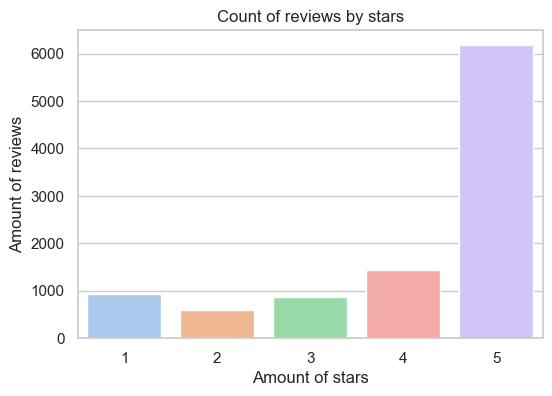

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
bar = sns.countplot(x='Score', data=df, ax=ax)
bar.set_xlabel('Amount of stars')
bar.set_ylabel('Amount of reviews')
bar.set_title('Count of reviews by stars')
plt.show()

Looks like the data is pretty unbalanced with a lot more reviews with 5 stars

### Getting an example

In [7]:
example = df.sample(1, random_state=123)['Text'].values[0]
example

'This is good iced tea.  It is hard to find locally in the Fall and Winter.'

# VADER sentiment score

VADER: **V**alence **A**ware **D**ictionary for S**E**ntiment **R**easoning

VADER is a NLP algorithm that blended a <u>sentiment lexicon</u> approach as well as <u>grammatical rules</u> and syntactical conventions for expressing sentiment polarity and intensity.

- **Sentiment lexicon**: The algorithm is constructed using a dictionary that contains a comprehensive list of sentiment features. VADER's lexical dictionary contains speech expressions such as "bad ass", emojicons such as ":)" and sentiment-laden acronyms such as "WTF". The lexical features have been rated by 10 independent human raters in a scale of -4 to +4 that goes from "extremely negative" to "extremely positive". Finally the average score is used as the final indicator of the sentiment feature. The dictionary contains around 7500 sentiment features of which none are scored as "0 - neutral".

- **Grammatical rules**: The developers incorporated several heuristic rules to handle cases of punctuation, capitalization, adverbs and conjunctions to handle complex linguistic constructions. Most of the complex constructions involve the use of neutral words such as "very" that may change the sentiment of the sentence depending on the whole context. For instance: "This computer is very good" and "This computer is very bad". The model also accounts for capitalization thus making the sentence "This computer is VERY good" more positive than "This computer is very good".

Note: To use the VADER model you need to install the <a href="https://www.nltk.org/data.html">NLTK data</a> running the following commands:

```python
>>> pip install nltk
>>> nltk.download()
```

This command will prompt a new window with the available data for download and automatically place it on the central folder to be used on other projects.

In [8]:
# Instantiate VADER
vader = SentimentIntensityAnalyzer()

In [9]:
# Running a quick test
vader.polarity_scores("I'm happy")

{'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}

The statement is overall positive. The "compound" score describes the summed up and normalized scores of the features found within the text. The compound score will return a number between -1 and 1 for a overall negative and positive text respectively.

In [10]:
print(example)
vader.polarity_scores(example)

This is good iced tea.  It is hard to find locally in the Fall and Winter.


{'neg': 0.077, 'neu': 0.765, 'pos': 0.158, 'compound': 0.3612}

## Checking the effect of grammatical rules

As mentioned before, the developers created several heuristic rules for the modern online-written language. Those heuristic rules seem to be working fine from the below example. We can see that incorporating the intensity adverb "very" returns a more positive score, incorporating the adverb all in caps returns an even more positive score and finally adding an exclamation mark returns an even more positive score.

In [11]:
sentences = [
    "I am happy",
    "I am very happy",
    "I am VERY happy",
    "I am VERY happy!",
]
for s in sentences:
    print(f"{s} {vader.polarity_scores(s)['compound']}")

I am happy 0.5719
I am very happy 0.6115
I am VERY happy 0.6933
I am VERY happy! 0.72


## Apply the model to the data

In [12]:
df[['vader_neg', 'vader_neu', 'vader_pos', 'vader_comp']] = df['Text'].apply(lambda x: vader.polarity_scores(x)).apply(pd.Series)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,vader_neg,vader_neu,vader_pos,vader_comp
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,0.000,0.695,0.305,0.9441
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.138,0.862,0.000,-0.5664
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,0.091,0.754,0.155,0.8265
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0.000,1.000,0.000,0.0000
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,0.000,0.552,0.448,0.9468


## Plot VADER results

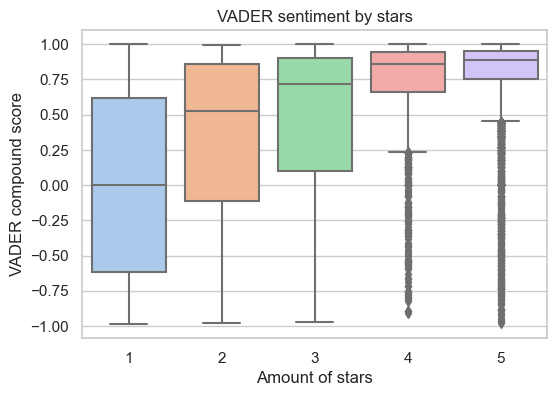

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
bar = sns.boxplot(x='Score', y='vader_comp', data=df, ax=ax)
bar.set_xlabel('Amount of stars')
bar.set_ylabel('VADER compound score')
bar.set_title('VADER sentiment by stars')
plt.show()

Looks like the VADER model brings valuable information to the data and can be used to generate new features. The compound score seems to be correlated to the amount of stars given for a product, thus the model is able to estimate if the product was or not positive for the user based on the user's opinion.

# Transfer learning using ROBERTA

(Actually Twitter-RoBERTa-sentiment which is a task-specific model which means it's a model for the task "sentiment analysis")

roBERTa: "Robustly Optimized BERT Pretraining Approcah" is a transformer model built on top of BERT and modifies key hyperparameters, removing the next-sentence pre-training objective and training with much larger mini-batches and learning rates.

Basically it's a pre-trained transformer model which was trained using ~58M to perform the sentiment classification task (0: negative, 1: neutral, 2: positive)

Note: If there's an OSError try re-running the program as an administrator.

In [14]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [15]:
example

'This is good iced tea.  It is hard to find locally in the Fall and Winter.'

In [16]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores) # returns the probability of each class
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2],
}
scores_dict

{'roberta_neg': 0.0067143026,
 'roberta_neu': 0.06481945,
 'roberta_pos': 0.9284661}

## Create a helper function to map the text into the polarity scores

In [17]:
def roberta_polarity_scores(text):
    """
    returns a dict of ploarity (negative, neutral, positive) scores for a text sequence.
    
    """
    encoded_text = tokenizer(text, 
                             return_tensors='pt', 
                             max_length=500, # Max length
                             truncation=True)
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2],
    }
    return scores_dict

## Apply the model to the data

In [18]:
df[['roberta_neg', 'roberta_neu', 'roberta_pos']] = df['Text'].apply(lambda x: roberta_polarity_scores(x)).apply(pd.Series)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,vader_neg,vader_neu,vader_pos,vader_comp,roberta_neg,roberta_neu,roberta_pos
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063


## Plot ROBERTA results

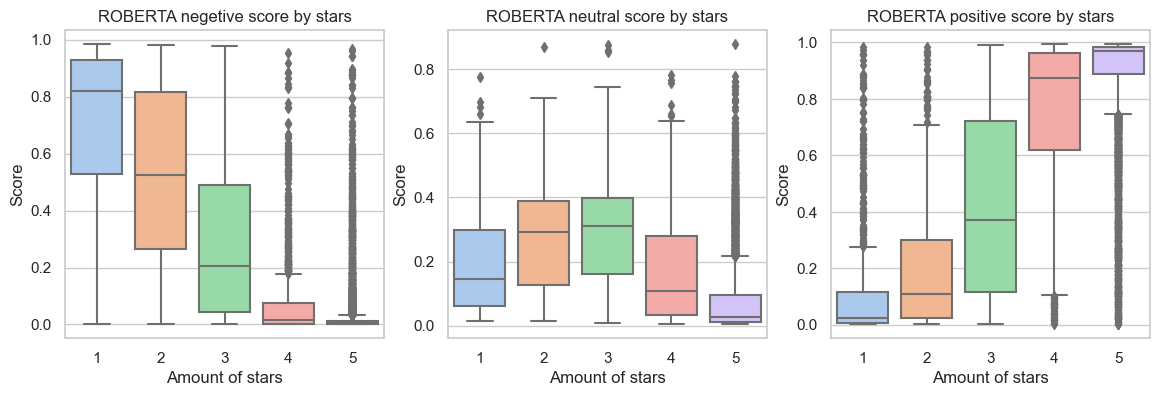

In [19]:
cols = ['roberta_neg', 'roberta_neu', 'roberta_pos']
titles = ['negetive', 'neutral', 'positive']
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for i, ax in enumerate(axes):
    box = sns.boxplot(x='Score', y=cols[i], data=df, ax=ax)
    box.set_xlabel('Amount of stars')
    box.set_ylabel('Score')
    box.set_title(f'ROBERTA {titles[i]} score by stars')
plt.show()

It seems ROBERTA has a good score behavior in relation to the actual score provided by the final users. 

- For the negative scores, the 1 and 2 stars reviews have the highest median and the third and fourth quartile are on the upper side of the boxplot.

- For the neutral scores, the highest median belongs to the 3 star ratings which represent the average between positivity and negativity so it's within the expected behavior.

- For the positive scores, the 4 and 5 star ratings have the highest median thus indicating that the positive scores follow the ratings' tendency.

# Compare VADER x ROBERTA

In [20]:
def linear_regression(x, y=None):
    """
    Fits x and y to a line and returns the slope, intercept and r-squared.
    
    """
    reg = linregress(x=x, y=y)
    slope, intercept, rvalue = reg.slope, reg.intercept, reg.rvalue 
    return slope, intercept, rvalue

## Negative scores

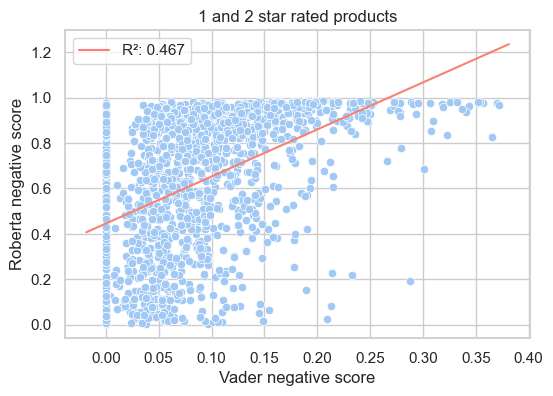

In [21]:
# Add linear tendency line
data = df.loc[df['Score'] < 3].copy(deep=True) # Filter 1 and 2 star ratings
slope, intercept, rvalue = linear_regression(x=data['vader_neg'], y=data['roberta_neg'])

fig, ax = plt.subplots(figsize=(6, 4))
scatter = sns.scatterplot(x='vader_neg',
                          y='roberta_neg',
                          data=data,
                          ax=ax)
scatter.set_xlabel('Vader negative score')
scatter.set_ylabel('Roberta negative score')
scatter.set_title('1 and 2 star rated products')

x = np.arange(*scatter.get_xlim(), step=0.01)
y = slope*x + intercept
line = sns.lineplot(x=x, y=y, label=f'R²: {round(rvalue, 3)}', color='salmon')
plt.show()

## Neutral scores

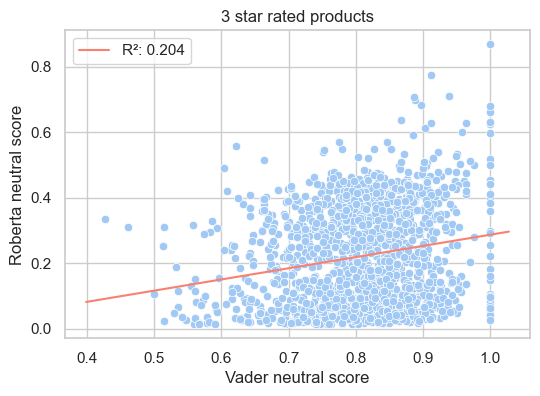

In [22]:
# Add linear tendency line
data = df.loc[df['Score'] < 3].copy(deep=True) # Filter 3 star ratings
slope, intercept, rvalue = linear_regression(x=data['vader_neu'], y=data['roberta_neu'])

fig, ax = plt.subplots(figsize=(6, 4))
scatter = sns.scatterplot(x='vader_neu',
                          y='roberta_neu',
                          data=data,
                          ax=ax)
scatter.set_xlabel('Vader neutral score')
scatter.set_ylabel('Roberta neutral score')
scatter.set_title('3 star rated products')

x = np.arange(*scatter.get_xlim(), step=0.01)
y = slope*x + intercept
line = sns.lineplot(x=x, y=y, label=f'R²: {round(rvalue, 3)}', color='salmon')
plt.show()

## Positive scores

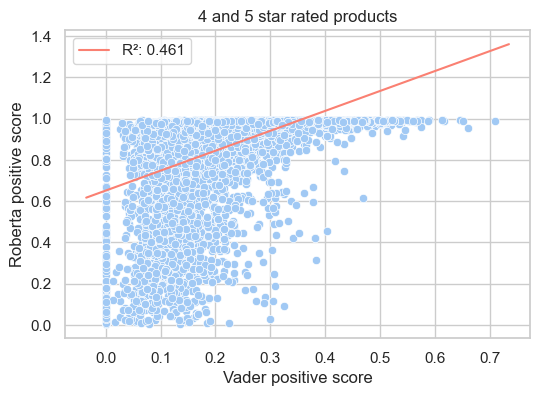

In [23]:
# Add linear tendency line
data = df.loc[df['Score'] > 3].copy(deep=True) # Filter 4 and 5 star ratings
slope, intercept, rvalue = linear_regression(x=data['vader_pos'], y=data['roberta_pos'])

fig, ax = plt.subplots(figsize=(6, 4))
scatter = sns.scatterplot(x='vader_pos',
                          y='roberta_pos',
                          data=data,
                          ax=ax)
scatter.set_xlabel('Vader positive score')
scatter.set_ylabel('Roberta positive score')
scatter.set_title('4 and 5 star rated products')

x = np.arange(*scatter.get_xlim(), step=0.01)
y = slope*x + intercept
line = sns.lineplot(x=x, y=y, label=f'R²: {round(rvalue, 3)}', color='salmon')
plt.show()

Looks like Roberta is able to differentiate the positives and negatives better than the Vader model, because from the actual positive and negative ratings the concentration of the scatter plots are on the top left part which thus meaning a greater Roberta score for a smaller Vader score.

# What's next?

Although this mini-project didn't involve any specific training of a model it provided valuable information on the sentiment analysis field as well as a good practice.

With this in mind the sentiment analysis field has a really broad applications spectrum:

- Social media monitoring.
- Brand monitoring and reputation management.
- Listen to voice of the customer (VoC)
- Product analysis.
- Market research and competitive research.

So we could use this type of insights to improve our products' overall performance on the market and monitor how well our brand is going using social medias such as Twitter.